In [1]:
####################################################
#
# T E S T   D A T A   G E N E R A T I O N
#
# this code is not part of mendonca algorithm
# and used only for experiment purpose in
# order to generate cameras and points
# 
####################################################

In [2]:
import numpy as np
import cv2
import scipy.optimize as opt
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

np.set_printoptions(suppress=True)

In [3]:
rng = np.random.default_rng(3122787423)

In [4]:
def plot_3d(x,y,z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x,y,z)
    plt.show()

In [5]:
def p3t(T,x,y,z):
    # apply a Projective 3D Transform
    xyz = np.concatenate((x, y, z),axis=1)
    column_ones = np.ones((len(x),1))
    tmp = T @ (np.concatenate((xyz,column_ones),axis=1)).T
    xp = (tmp[0,:]/tmp[3,:]).T
    yp = (tmp[1,:]/tmp[3,:]).T
    zp = (tmp[2,:]/tmp[3,:]).T
    return xp,yp,zp

In [6]:
def projf(P,x,y,z):
# PROJ  compute perspective projection (from 3D to pixel coordinates)
# pixel positions are returned with floating point precision
    c3d = np.concatenate((x, y, z),axis=1)
    column_ones = np.ones((len(x),1))
    h3d = (np.concatenate((c3d,column_ones),axis=1)).T
    h2d = P @ h3d

    c2d = h2d/ h2d[2,:]

    u = c2d[0,:].T
    v = c2d[1,:].T
    return u,v

In [7]:
def plot_2d(points):  
    # input: matrix that consists array of points (x,y) per image
    num_of_images =  points.shape[2]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    colors = cm.rainbow(np.linspace(0, 1, num_of_images))
    for image in range(num_of_images):
        x = points[:,0,image]
        y = points[:,1,image]
        plt.scatter(x, y, color=colors[image])
    plt.show()

In [8]:
def plot_2d_separate(points):
    # input: matrix that consists array of points (x,y) per image
    num_of_images = points.shape[2]
    plot_columns = int(round(math.sqrt(num_of_images)))
    plot_rows = int(round(math.sqrt(num_of_images)))+1
    fig, axes = plt.subplots(plot_columns,plot_rows, figsize=(20, 10))
    for i, ax in enumerate(axes.ravel()):
        if(i < num_of_images):
            x = points[:,0,i]
            y = points[:,1,i]
            ax.set_title("Camera {}".format(i))
            ax.scatter(x, y)
    plt.show()

In [9]:
def conver_to_col(x):
    return np.reshape(x,(len(x),1))

In [10]:
def rcam(A):
# RCAM generate a random camera
#    generate a random camera pointing to lookp, positioned at an average 
#    distance ad form the origin, with a std dev of sd 
#    A is the intrinsic parameters matrix

    ad=2.5
    sd=0.25
    lookp=np.zeros((1,3))
    eyep = rng.uniform(-1,1,size=(1,3))-0.5
    R = np.zeros((3,3))
    eyep = eyep/np.linalg.norm(eyep) * (ad + sd*rng.random(1))

    R[2,:] = lookp - eyep/np.linalg.norm(lookp - eyep)
    R[1,:] = np.cross(R[2,:],rng.uniform(size=(1,3)))
    R[1,:] = R[1,:]/np.linalg.norm(R[1,:])
    R[0,:] = np.cross(R[1,:],R[2,:])
    Rt = np.concatenate((R,-R @ eyep.T),axis=1)

    return A @ Rt


In [11]:
numberOfViews = 5
numberOfPoints = 50
imagePoints = np.zeros((numberOfPoints,2,numberOfViews))

cameras = np.zeros((3,4,numberOfViews))

In [12]:
def create_fake_points():
    data = (rng.uniform(size=(numberOfPoints,3),)-0.5)/(math.sqrt(3)/2)
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]
    return x, y, z

In [13]:
true_K = np.array([
    [800,0,256],
    [0,800,256],
    [0,0,1]
    ])
x_init, y_init, z_init = create_fake_points()
A = true_K
P = rcam(A)
invAP = np.linalg.inv(A) @ P
lower_line = [[0,0,0,1]]
G0 = np.concatenate((invAP, lower_line),axis=0)

In [14]:
x,y,z = p3t(
    G0,
    conver_to_col(x_init),
    conver_to_col(y_init),
    conver_to_col(z_init)
)
P = A @ np.concatenate((np.identity(3), np.zeros((3,1))),axis=1)

u,v = projf(P,conver_to_col(x),conver_to_col(y),conver_to_col(z))

imagePoints[:,0,0] = u
imagePoints[:,1,0] = v
cameras[:,:,0] = P

In [15]:
for view in range (1,numberOfViews):
    # random camera position
    P = rcam(A)
    # apply world coordinate transformation
    P = P @ np.linalg.inv(G0);
    # project world points to image points
    u,v = projf(P,conver_to_col(x),conver_to_col(y),conver_to_col(z))
    imagePoints[:,0,view] = u
    imagePoints[:,1,view] = v
    cameras[:,:,view] = P   

# A Simple Technique for Self-Calibration
Alexander Kruglyak

Sofya Zybtsovsky

### Introduction
The goal of Computer Vision is to compute properties (mainly geometric) of the three-dimensional world from images.
One of the challenging problems of Computer Vision is to reconstruct a 3D model of a scene from a moving camera.
<br>Possible applications include: navigation of autonomous vehicles, objects recognition, reverse engineering and synthesis of virtual environments.


Given all the parameters of the camera (intrinsic, extrinsic), reconstruction is straightforward. <br>
Intrinsic parameters (focal length, image center and aspect ratio) are playing significant role in fundamental computer vision problems. <br>

In many cases those parameters are unknown...

### Projection

We want a mathematical model to describe how 3D World points get projected into 2D Pixel coordinates.

### Forward projection


<center><img src="images/forward_projection.png"></center>

### Backward projection

<center><img src="images/backward_projection.png"></center>

## Mathematical model

<center><img src="images/ProjectionMatrix.jpg"></center>

## Self-calibration
Self-calibration is the process of finding intrinsic parameters of the camera without any actual calibration object:
- focal length
- image center (principal point)
- aspect ratio (pixel skew)

### Intrinsic matrix K
5 degrees of freedom: 2 for focal length, 2 for offset, and 1 for skewness

<center><img src="images/K_matrix.png"></center>

## Mendonca's approach to find calibration matrix

### Mendonca - algorithm
- extension of Hartley’s self-calibration technique
- Input: at least 24 points (3+ images such as each contains 8+ correspondence points)
- Output: <b>all</b> intrinsic parameters

### Mendonca - algorithm
Based on the theorem of essential matrix E=[T]<sub>x</sub>R:

A real matrix E<sub>3x3</sub> can be factorized as product of a nonzero skew-symmetric matrix <b>T</b> (translation) and a rotation matrix <b>R</b> 
<br><b>if and only if</b>
<br>E has 2 identical singular values and a zero singular value
<br><br>E<sub>3x3</sub> =[T]<sub>x</sub>R   <=>    <sup>1</sup>𝞼=<sup>2</sup>𝞼, <sup>3</sup>𝞼=0

<center><img src="images/camera_translation.png"></center>

<center><img src="images/camera_rotation.png"></center>

### Mendonca - algorithm
<br><br>algo aims to find 2 singular values (other than zero) 
that are as close as possible:
<br><br><sup>1</sup>𝞼 - <sup>2</sup>𝞼 -> 0
<br><br>K found by algo -> true intrinsic matrix

### Mendonca algorithm
Input: at least 24 points (3+ images such as each contains 8+ correspondence points)

Output:  K (intrinsic  parameters)

1. Init some random matrix K
2. Calculate fundamental matrix <b>F</b> for each pair of images
3. Calculate essential matrix <b>E</b> for each pair of images (based on F and K)
4. Decompose E and find singular values (SVD)
4. Calculate error (cost function)
6. Minimize error
7. Then cost function reach global minimum: return K


### Input
50 points with 5 different views

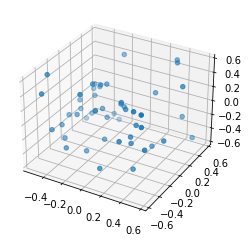

In [16]:
plot_3d(x_init,y_init,z_init)

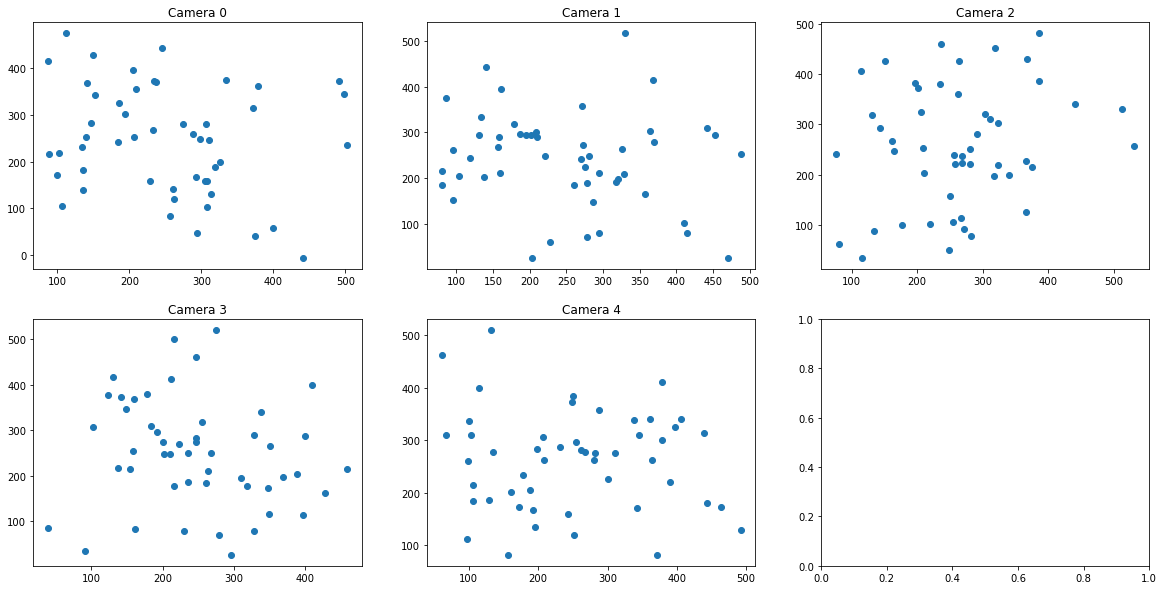

In [17]:
plot_2d_separate(imagePoints)

### 1. Init some random matrix K

In [18]:
initial_K = [100,0,100,200]
print(np.array([[initial_K[0],0,initial_K[1]],[0,initial_K[2],initial_K[3]],[0,0,1]]))

[[100   0   0]
 [  0 100 200]
 [  0   0   1]]


### 2. Calculate fundamental matrix F for each pair of images (for example via 8-point algorithm with data normalization)


In [19]:
def calc_fund_matrix(points1,points2):
    '''
    Takes in 2 arrays of matching points 
    Return Fundamental matrix 
    '''
    F, mask = cv2.findFundamentalMat(points1,points2, cv2.FM_8POINT)

    return F 

Fs = np.zeros((3,3,numberOfViews,numberOfViews))

for i in range(numberOfViews):
    for j in range(i+1,numberOfViews):
        Fs[:,:,i,j] = calc_fund_matrix(imagePoints[:,:,i],imagePoints[:,:,j])

1. Normalize points
2. Construct the M x 9 matrix A
3. Find the SVD of ATA
4. Entries of F are the elements of column of V corresponding to the least singular value
5. Enforce rank 2 constraint on F - by forcing least singular value to be 0
6. Un-normalize F

### 3. Calculate essential matrix E for each pair of images (based on F and K)

In [20]:
def calculate_essential_matrix(K,F):
    return K.T @ F @ K

### 4. Decompose E and find singular values (SVD)

In [21]:
def decompose_singular_values(E):
    _,D,_ = np.linalg.svd(E)
    # Singular Values (3rd value, D[3] is 0 according to theorem)
    r = D[0]
    s = D[1]
    return r, s

### 5. Calculate error (cost function)

<sup>1</sup>𝞼<sub>ij</sub> , <sup>2</sup>𝞼<sub>ij</sub>  - non zero singular values of E<sub>ij</sub> = K<sup>T</sup><sub>i</sub>F<sub>ij</sub>K<sub>j</sub>, such as <sup>1</sup>𝞼<sub>ij</sub> > <sup>2</sup>𝞼<sub>ij</sub>

w<sub>ij</sub> - normalized weight factors

Minimize cost function:
<center><img src="images/cost_function.png"></center>

In [22]:
def mendonca_cost_func(X):
    '''
    computes Mendonca & Cipolla Cost function to find the Optimal Intrinsic Parameters
    Input
    X      - Approximate Values of Intrinsics - 1D array with length 4
    Output
    cost    - Computed Cost
    '''

    K = np.array([
        [X[0],0,X[1]],
        [0,X[2],X[3]],
        [0,0,1]
    ])
    cost = 0
    nof_images = numberOfViews
    Den = nof_images*(nof_images-1)/2 

    for i in range(0,nof_images-1):
        for j in range (i+1,nof_images):
            E = calculate_essential_matrix(K, Fs[:,:,i,j])
            r,s = decompose_singular_values(E)
            cost+= (1/Den) * (r - s)/s

    return cost

### 6. Minimize error 

In [23]:
res = opt.minimize(mendonca_cost_func,x0=initial_K, method='Nelder-Mead')

### 7. Then cost function reach global minimum: return K

In [24]:
result_K = np.array([
    [ res.x[0], 0 ,       res.x[1] ],
    [ 0,        res.x[2], res.x[3] ],
    [ 0,        0,        1        ]
])
print ("Result K\n",np.matrix(result_K))
print("True K\n",true_K)

Result K
 [[800.00263942   0.         256.00003809]
 [  0.         800.00260095 256.00004742]
 [  0.           0.           1.        ]]
True K
 [[800   0 256]
 [  0 800 256]
 [  0   0   1]]


### Mendonca | Advantages

- simple mathematical calculation

- find all unknown intrinsic camera parameters

- always converges to the global minimum

- has no bias towards any particular image of the sequence

- insensitive to the initialization


In [25]:
initial_K = [250,50,100,150]
res = opt.minimize(mendonca_cost_func,x0=initial_K, method='Nelder-Mead')
result_K = np.zeros((3,3))
result_K = np.array([[res.x[0],0,res.x[1]],[0,res.x[2],res.x[3]],[0,0,1]])
print (np.matrix(result_K))

[[800.00288859   0.         256.00006365]
 [  0.         800.00285677 256.00006033]
 [  0.           0.           1.        ]]


Mendonca, Paulo RS & Roberto Cipolla "A simple technique for self-calibration" 1999,  University of Cambridge, UK